In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
df_historical = pd.read_csv('AAPL_Historical.csv')
df_income = pd.read_csv('AAPL_Income_Statement.csv')
df_balance = pd.read_csv('AAPL_Balance_Sheet.csv')

print(f"Historical data: {df_historical.shape}")
print(f"Income statement: {df_income.shape}")
print(f"Balance sheet: {df_balance.shape}")

Historical data: (11288, 8)
Income statement: (39, 6)
Balance sheet: (68, 6)


In [ ]:
df_historical['Date'] = pd.to_datetime(df_historical['Date'], errors='coerce')
df_historical = df_historical.dropna(subset=['Date']).sort_values('Date')
df_historical['Year'] = df_historical['Date'].dt.year
df_historical['Month'] = df_historical['Date'].dt.month
df_historical['Day'] = df_historical['Date'].dt.day
df_historical['DayOfWeek'] = df_historical['Date'].dt.dayofweek
df_historical['Quarter'] = df_historical['Date'].dt.quarter


In [6]:
df_historical['Returns'] = df_historical['Close'].pct_change()
df_historical['Log_Returns'] = np.log(df_historical['Close'] / df_historical['Close'].shift(1))

df_historical['MA_7'] = df_historical['Close'].rolling(window=7).mean()
df_historical['MA_30'] = df_historical['Close'].rolling(window=30).mean()
df_historical['MA_90'] = df_historical['Close'].rolling(window=90).mean()

df_historical['Volatility_30'] = df_historical['Returns'].rolling(window=30).std()

df_historical['Momentum_5'] = df_historical['Close'] - df_historical['Close'].shift(5)
df_historical['Momentum_10'] = df_historical['Close'] - df_historical['Close'].shift(10)

In [7]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_historical['RSI_14'] = calculate_rsi(df_historical['Close'])

ema_12 = df_historical['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df_historical['Close'].ewm(span=26, adjust=False).mean()
df_historical['MACD'] = ema_12 - ema_26
df_historical['Signal_Line'] = df_historical['MACD'].ewm(span=9, adjust=False).mean()

In [8]:
df_historical['BB_Middle'] = df_historical['Close'].rolling(window=20).mean()
bb_std = df_historical['Close'].rolling(window=20).std()
df_historical['BB_Upper'] = df_historical['BB_Middle'] + (bb_std * 2)
df_historical['BB_Lower'] = df_historical['BB_Middle'] - (bb_std * 2)

df_historical['HL_Spread'] = df_historical['High'] - df_historical['Low']
df_historical['HL_PCT'] = (df_historical['High'] - df_historical['Low']) / df_historical['Close'] * 100

df_historical['Volume_MA_30'] = df_historical['Volume'].rolling(window=30).mean()
df_historical['Volume_Ratio'] = df_historical['Volume'] / df_historical['Volume_MA_30']

df_historical['Target'] = df_historical['Close'].shift(-1)

print(f"Technical indicators calculated")

Technical indicators calculated


In [9]:
df_income_T = df_income.set_index('Unnamed: 0').T
df_income_T.index = pd.to_datetime(df_income_T.index)
df_income_T['Year'] = df_income_T.index.year

df_balance_T = df_balance.set_index('Unnamed: 0').T
df_balance_T.index = pd.to_datetime(df_balance_T.index)
df_balance_T['Year'] = df_balance_T.index.year

In [10]:
income_metrics = [
    'Normalized EBITDA', 'Net Income From Continuing Operation Net Minority Interest',
    'Reconciled Depreciation'
]
balance_metrics = [
    'Total Debt', 'Net Debt', 'Ordinary Shares Number', 'Total Assets'
]

In [11]:
available_income = [col for col in income_metrics if col in df_income_T.columns]
available_balance = [col for col in balance_metrics if col in df_balance_T.columns]

financial_data = pd.DataFrame()
if available_income:
    financial_data = df_income_T[available_income + ['Year']].copy()
if available_balance:
    balance_yearly = df_balance_T[available_balance + ['Year']].copy()
    if financial_data.empty:
        financial_data = balance_yearly
    else:
        financial_data = financial_data.merge(balance_yearly, on='Year', how='outer')

if not financial_data.empty:
    df_merged = df_historical.merge(financial_data, on='Year', how='left')
    financial_cols = [col for col in financial_data.columns if col != 'Year']
    for col in financial_cols:
        df_merged[col] = df_merged.groupby('Year')[col].ffill()
        df_merged[col] = df_merged.groupby('Year')[col].bfill()
else:
    df_merged = df_historical.copy()
    financial_cols = []

print(f"Merged dataset shape: {df_merged.shape}")

Merged dataset shape: (4512, 39)


In [12]:
df_merged = df_merged.dropna(subset=['Target'])

In [13]:
df_merged.to_csv('apple_merged_data.csv', index=False)
print("Saved: apple_merged_data.csv")

Saved: apple_merged_data.csv


In [14]:
feature_columns = [
    'Open', 'High', 'Low', 'Volume',
    'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter',
    'Returns', 'MA_7', 'MA_30', 'MA_90',
    'Volatility_30', 'Momentum_5', 'Momentum_10',
    'RSI_14', 'MACD', 'Signal_Line',
    'BB_Middle', 'BB_Upper', 'BB_Lower',
    'HL_Spread', 'HL_PCT', 'Volume_Ratio'
]

feature_columns.extend(financial_cols)

df_ml = df_merged[feature_columns + ['Target', 'Close']].dropna()

X = df_ml[feature_columns]
y = df_ml['Target']

print(f"✓ Features: {len(feature_columns)}")
print(f"✓ Samples: {len(X)}")

split_index = int(len(X) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Training samples: {len(X_train)}")
print(f"✓ Test samples: {len(X_test)}")

✓ Features: 32
✓ Samples: 344
✓ Training samples: 275
✓ Test samples: 69


In [15]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=15),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=1.0, random_state=42),
    'SVR': SVR(kernel='rbf'),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=15),
    'AdaBoost': AdaBoostRegressor(n_estimators=50, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    
    results[name] = {
        'model': model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mape': test_mape,
        'predictions': y_pred_test
    }
    
    print(f" {name}: Test R²={test_r2:.4f}, RMSE=${test_rmse:.2f}, MAPE={test_mape:.2f}%")
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train_RMSE': [results[m]['train_rmse'] for m in results],
    'Test_RMSE': [results[m]['test_rmse'] for m in results],
    'Test_MAE': [results[m]['test_mae'] for m in results],
    'Test_R2': [results[m]['test_r2'] for m in results],
    'Test_MAPE': [results[m]['test_mape'] for m in results]
})
results_df.to_csv('model_performance_apple.csv', index=False)
print("\n✓ Saved: model_performance_apple.csv")

 Random Forest: Test R²=-0.5637, RMSE=$37.39, MAPE=12.71%
 Gradient Boosting: Test R²=-0.6348, RMSE=$38.23, MAPE=12.67%
 Linear Regression: Test R²=0.9545, RMSE=$6.38, MAPE=1.21%
 Ridge: Test R²=0.9521, RMSE=$6.54, MAPE=1.26%
 Lasso: Test R²=0.9312, RMSE=$7.84, MAPE=2.06%
 SVR: Test R²=-2.8997, RMSE=$59.05, MAPE=20.04%
 KNN: Test R²=-0.5894, RMSE=$37.70, MAPE=12.95%
 Decision Tree: Test R²=-0.6324, RMSE=$38.21, MAPE=13.35%
 AdaBoost: Test R²=-0.5850, RMSE=$37.65, MAPE=12.38%

✓ Saved: model_performance_apple.csv


In [16]:
import os
os.makedirs('apple_visualizations', exist_ok=True)

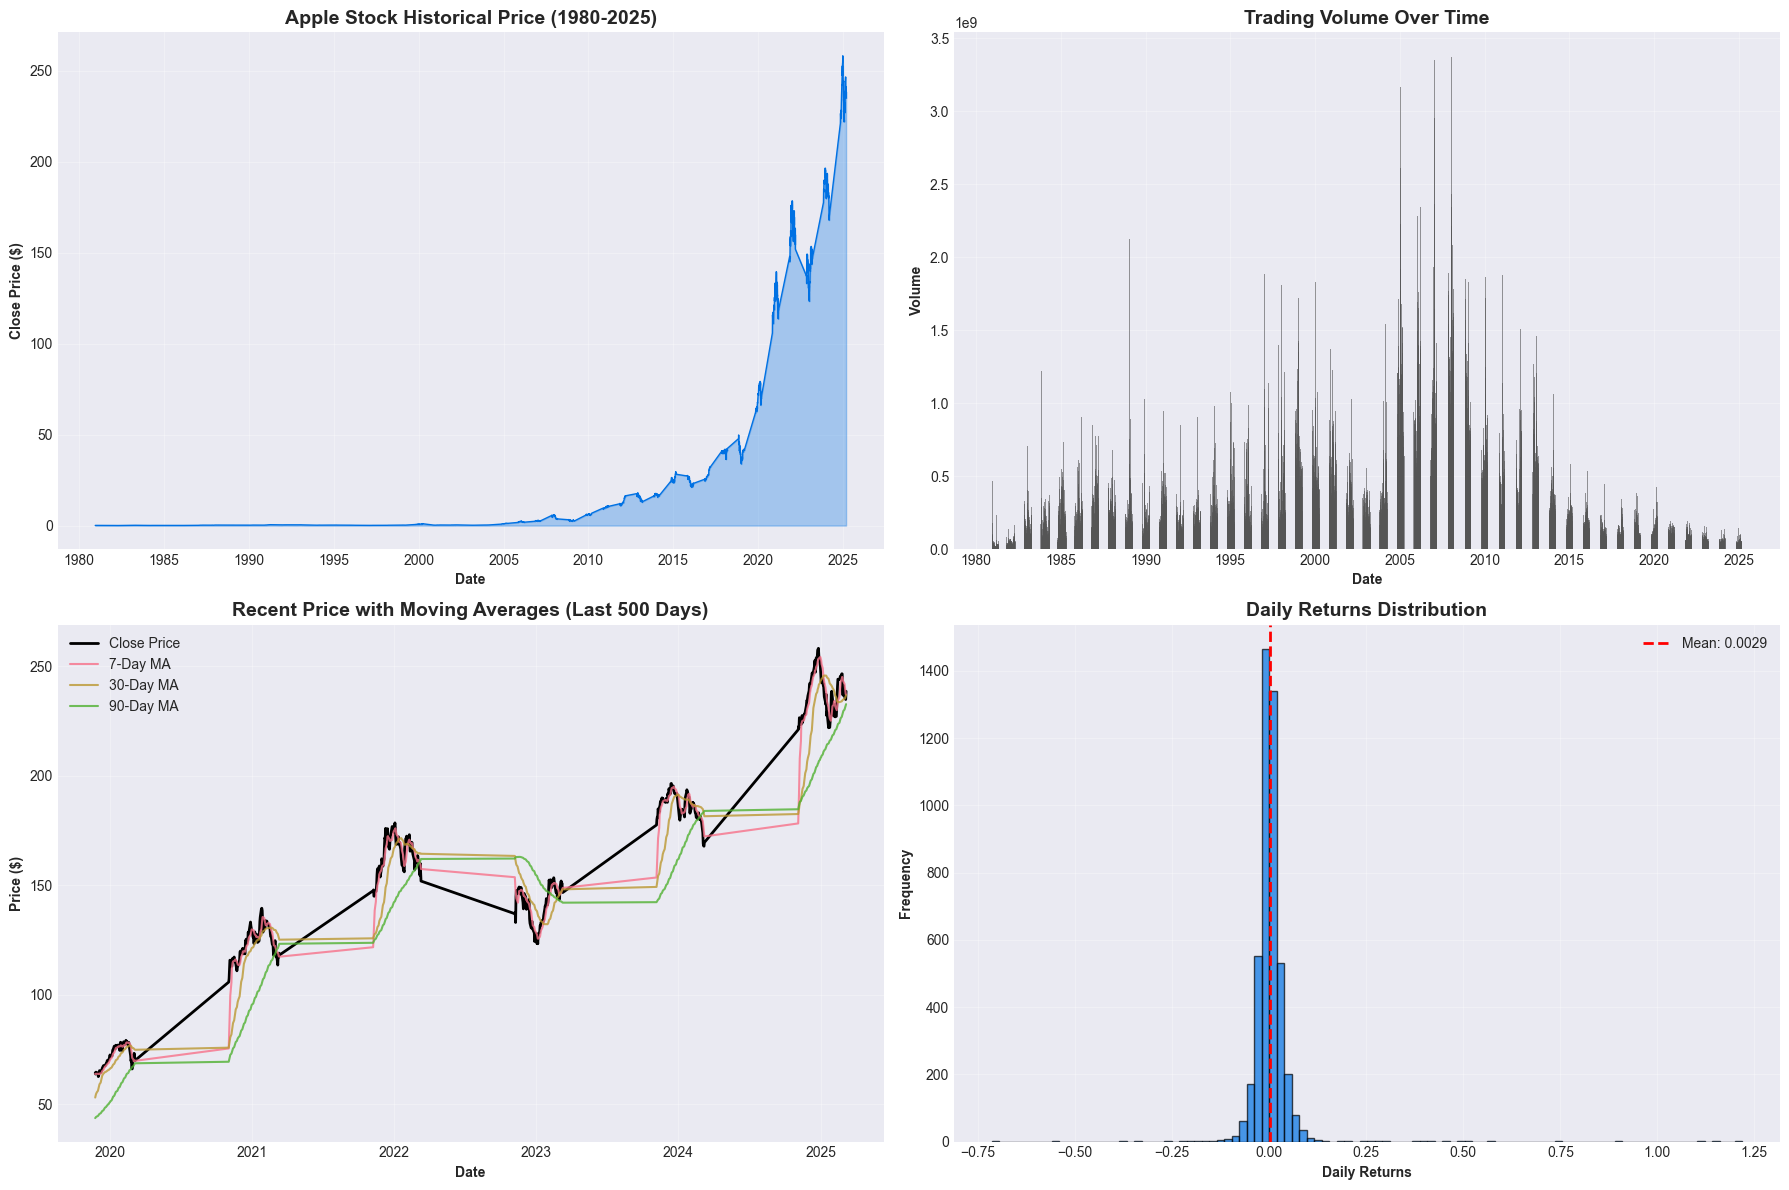

✓ Saved: 01_stock_overview.png


In [17]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

ax = axes[0, 0]
ax.plot(df_historical['Date'], df_historical['Close'], linewidth=1, color='#0071e3')
ax.fill_between(df_historical['Date'], df_historical['Close'], alpha=0.3, color='#0071e3')
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Close Price ($)', fontweight='bold')
ax.set_title('Apple Stock Historical Price (1980-2025)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

ax = axes[0, 1]
ax.bar(df_historical['Date'], df_historical['Volume'], width=20, color='#555555', alpha=0.6)
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Volume', fontweight='bold')
ax.set_title('Trading Volume Over Time', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

ax = axes[1, 0]
recent = df_historical.tail(500)
ax.plot(recent['Date'], recent['Close'], label='Close Price', linewidth=2, color='black')
ax.plot(recent['Date'], recent['MA_7'], label='7-Day MA', linewidth=1.5, alpha=0.8)
ax.plot(recent['Date'], recent['MA_30'], label='30-Day MA', linewidth=1.5, alpha=0.8)
ax.plot(recent['Date'], recent['MA_90'], label='90-Day MA', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Price ($)', fontweight='bold')
ax.set_title('Recent Price with Moving Averages (Last 500 Days)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1, 1]
returns_clean = df_historical['Returns'].dropna()
ax.hist(returns_clean, bins=100, color='#0071e3', alpha=0.7, edgecolor='black')
ax.axvline(returns_clean.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {returns_clean.mean():.4f}')
ax.set_xlabel('Daily Returns', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Daily Returns Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('apple_visualizations/01_stock_overview.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 01_stock_overview.png")

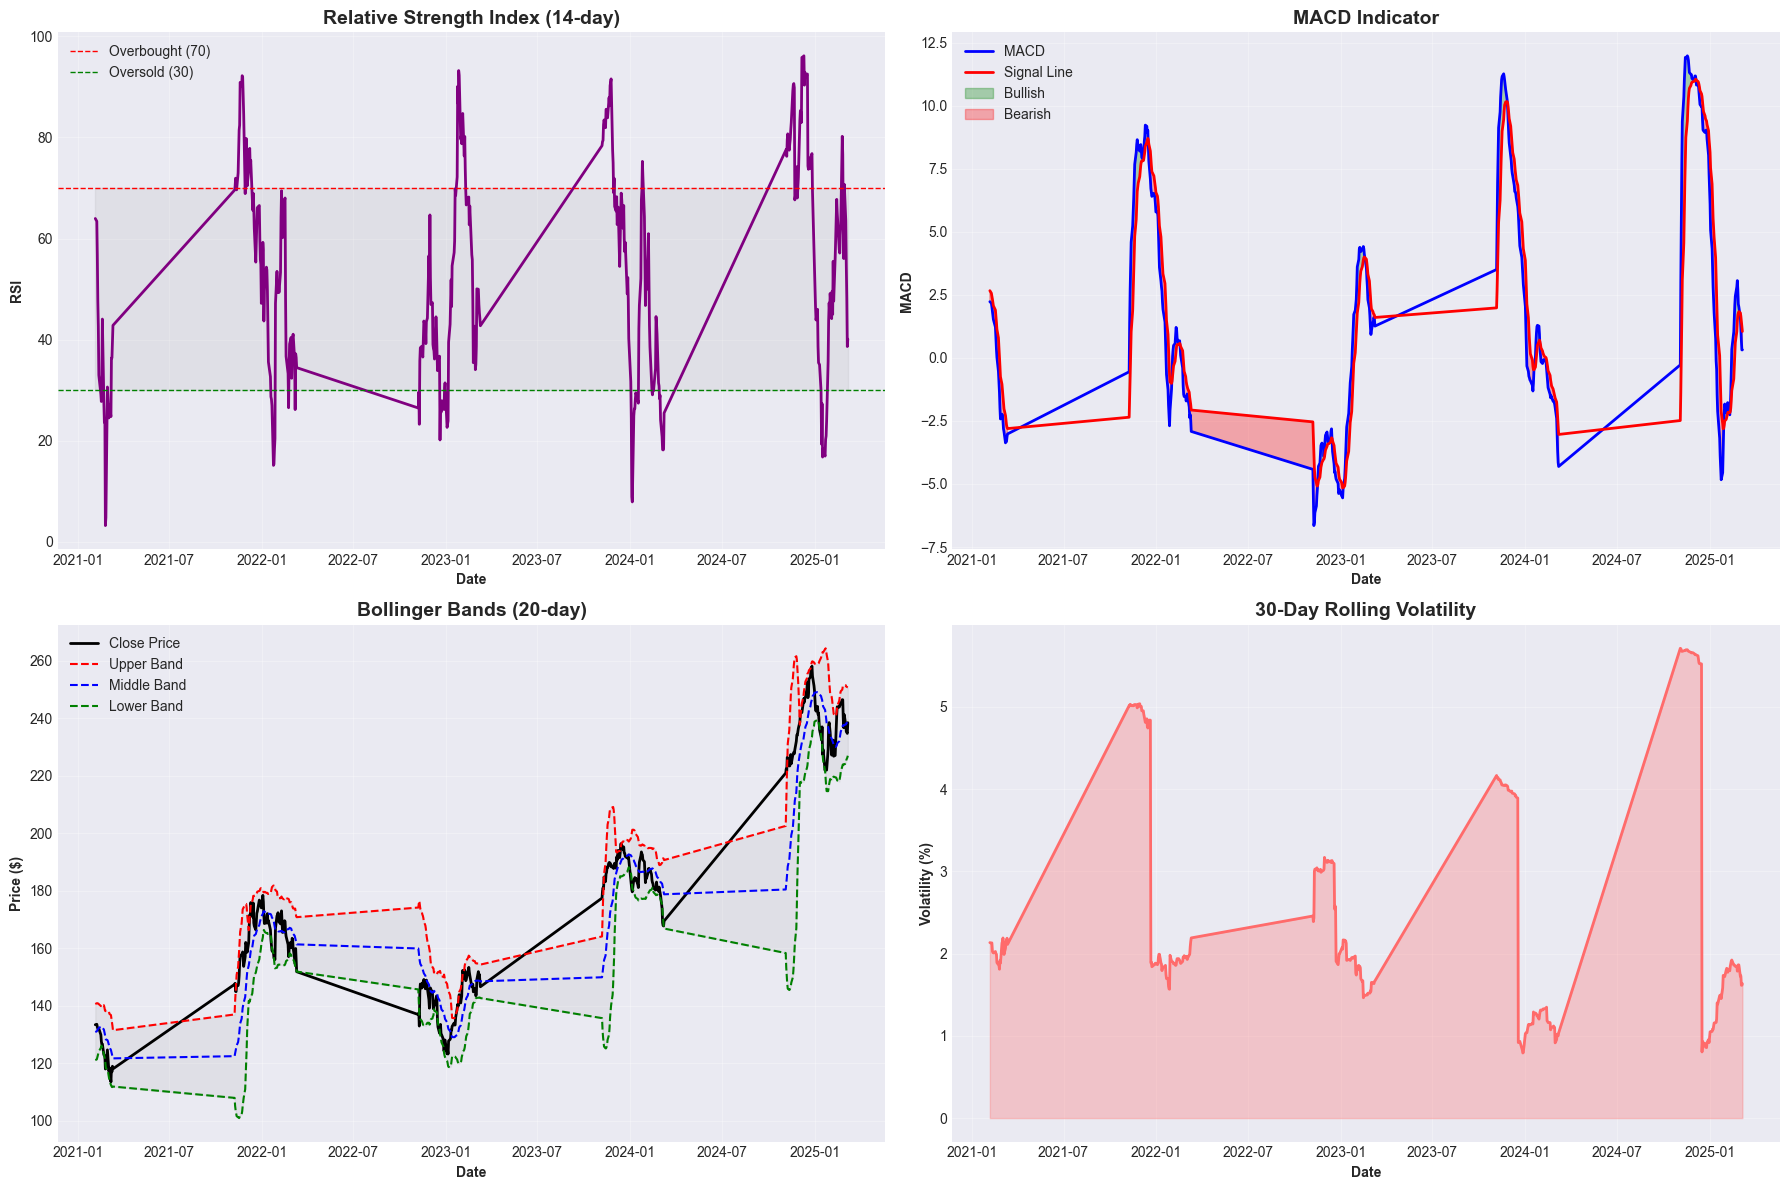

Saved: 02_technical_indicators.png


In [18]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

recent = df_historical.tail(365)

ax = axes[0, 0]
ax.plot(recent['Date'], recent['RSI_14'], linewidth=2, color='purple')
ax.axhline(70, color='red', linestyle='--', linewidth=1, label='Overbought (70)')
ax.axhline(30, color='green', linestyle='--', linewidth=1, label='Oversold (30)')
ax.fill_between(recent['Date'], 30, 70, alpha=0.1, color='gray')
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('RSI', fontweight='bold')
ax.set_title('Relative Strength Index (14-day)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

ax = axes[0, 1]
ax.plot(recent['Date'], recent['MACD'], label='MACD', linewidth=2, color='blue')
ax.plot(recent['Date'], recent['Signal_Line'], label='Signal Line', linewidth=2, color='red')
ax.fill_between(recent['Date'], recent['MACD'], recent['Signal_Line'], 
                where=recent['MACD'] >= recent['Signal_Line'], alpha=0.3, color='green', label='Bullish')
ax.fill_between(recent['Date'], recent['MACD'], recent['Signal_Line'],
                where=recent['MACD'] < recent['Signal_Line'], alpha=0.3, color='red', label='Bearish')
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('MACD', fontweight='bold')
ax.set_title('MACD Indicator', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1, 0]
ax.plot(recent['Date'], recent['Close'], label='Close Price', linewidth=2, color='black')
ax.plot(recent['Date'], recent['BB_Upper'], label='Upper Band', linewidth=1.5, linestyle='--', color='red')
ax.plot(recent['Date'], recent['BB_Middle'], label='Middle Band', linewidth=1.5, linestyle='--', color='blue')
ax.plot(recent['Date'], recent['BB_Lower'], label='Lower Band', linewidth=1.5, linestyle='--', color='green')
ax.fill_between(recent['Date'], recent['BB_Lower'], recent['BB_Upper'], alpha=0.1, color='gray')
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Price ($)', fontweight='bold')
ax.set_title('Bollinger Bands (20-day)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1, 1]
ax.plot(recent['Date'], recent['Volatility_30'] * 100, linewidth=2, color='#ff6b6b')
ax.fill_between(recent['Date'], recent['Volatility_30'] * 100, alpha=0.3, color='#ff6b6b')
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Volatility (%)', fontweight='bold')
ax.set_title('30-Day Rolling Volatility', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('apple_visualizations/02_technical_indicators.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("Saved: 02_technical_indicators.png")

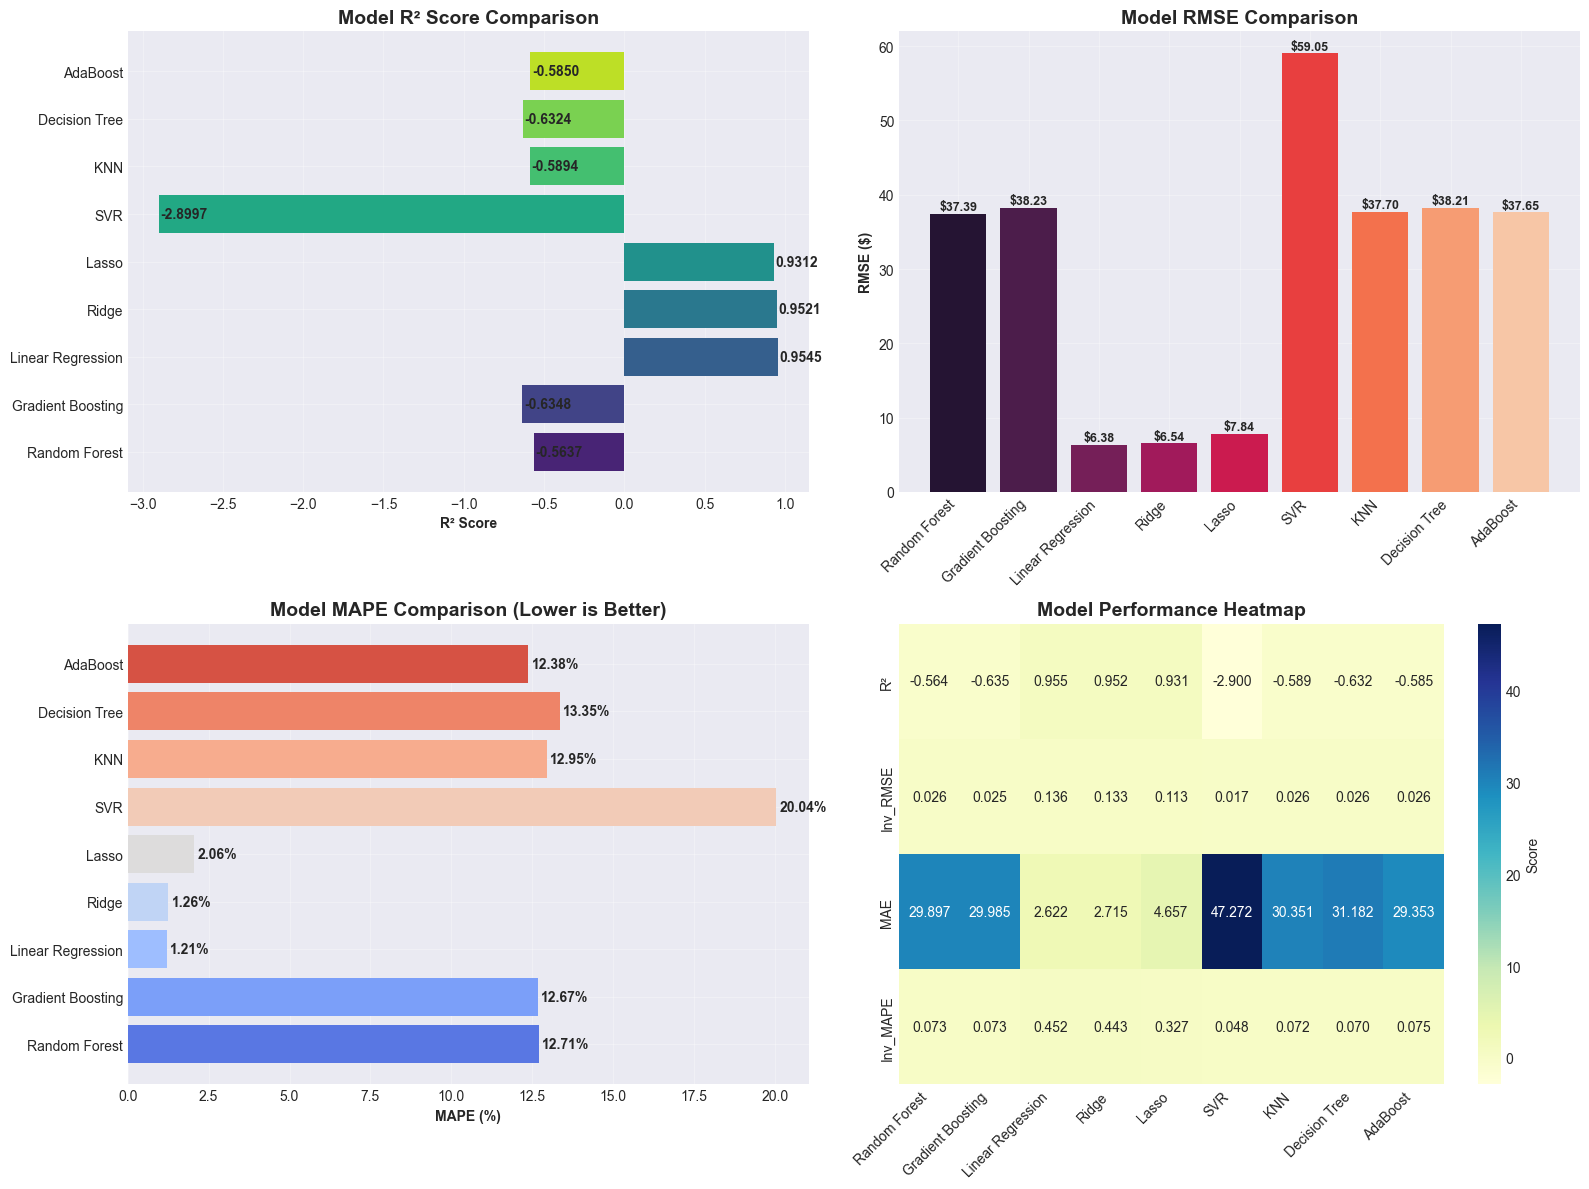

✓ Saved: 03_model_performance.png


In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

model_names = list(results.keys())

ax = axes[0, 0]
r2_scores = [results[m]['test_r2'] for m in model_names]
bars = ax.barh(model_names, r2_scores, color=sns.color_palette("viridis", len(model_names)))
ax.set_xlabel('R² Score', fontweight='bold')
ax.set_title('Model R² Score Comparison', fontsize=14, fontweight='bold')
for i, (bar, score) in enumerate(zip(bars, r2_scores)):
    ax.text(score + 0.01, i, f'{score:.4f}', va='center', fontsize=10, fontweight='bold')
ax.grid(alpha=0.3)

ax = axes[0, 1]
test_rmse = [results[m]['test_rmse'] for m in model_names]
bars = ax.bar(range(len(model_names)), test_rmse, color=sns.color_palette("rocket", len(model_names)))
ax.set_xticks(range(len(model_names)))
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylabel('RMSE ($)', fontweight='bold')
ax.set_title('Model RMSE Comparison', fontsize=14, fontweight='bold')
for bar, rmse in zip(bars, test_rmse):
    ax.text(bar.get_x() + bar.get_width()/2., rmse + 0.5,
            f'${rmse:.2f}', ha='center', fontsize=9, fontweight='bold')
ax.grid(alpha=0.3)

ax = axes[1, 0]
mape_scores = [results[m]['test_mape'] for m in model_names]
bars = ax.barh(model_names, mape_scores, color=sns.color_palette("coolwarm", len(model_names)))
ax.set_xlabel('MAPE (%)', fontweight='bold')
ax.set_title('Model MAPE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
for i, (bar, mape) in enumerate(zip(bars, mape_scores)):
    ax.text(mape + 0.1, i, f'{mape:.2f}%', va='center', fontsize=10, fontweight='bold')
ax.grid(alpha=0.3)

ax = axes[1, 1]
metrics_matrix = np.array([
    [results[m]['test_r2'] for m in model_names],
    [1 / (1 + results[m]['test_rmse']) for m in model_names],  # Normalized inverse RMSE
    [results[m]['test_mae'] for m in model_names],
    [1 / (1 + results[m]['test_mape']) for m in model_names]  # Normalized inverse MAPE
])
sns.heatmap(metrics_matrix, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=model_names, yticklabels=['R²', 'Inv_RMSE', 'MAE', 'Inv_MAPE'],
            cbar_kws={'label': 'Score'}, ax=ax)
ax.set_title('Model Performance Heatmap', fontsize=14, fontweight='bold')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('apple_visualizations/03_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 03_model_performance.png")

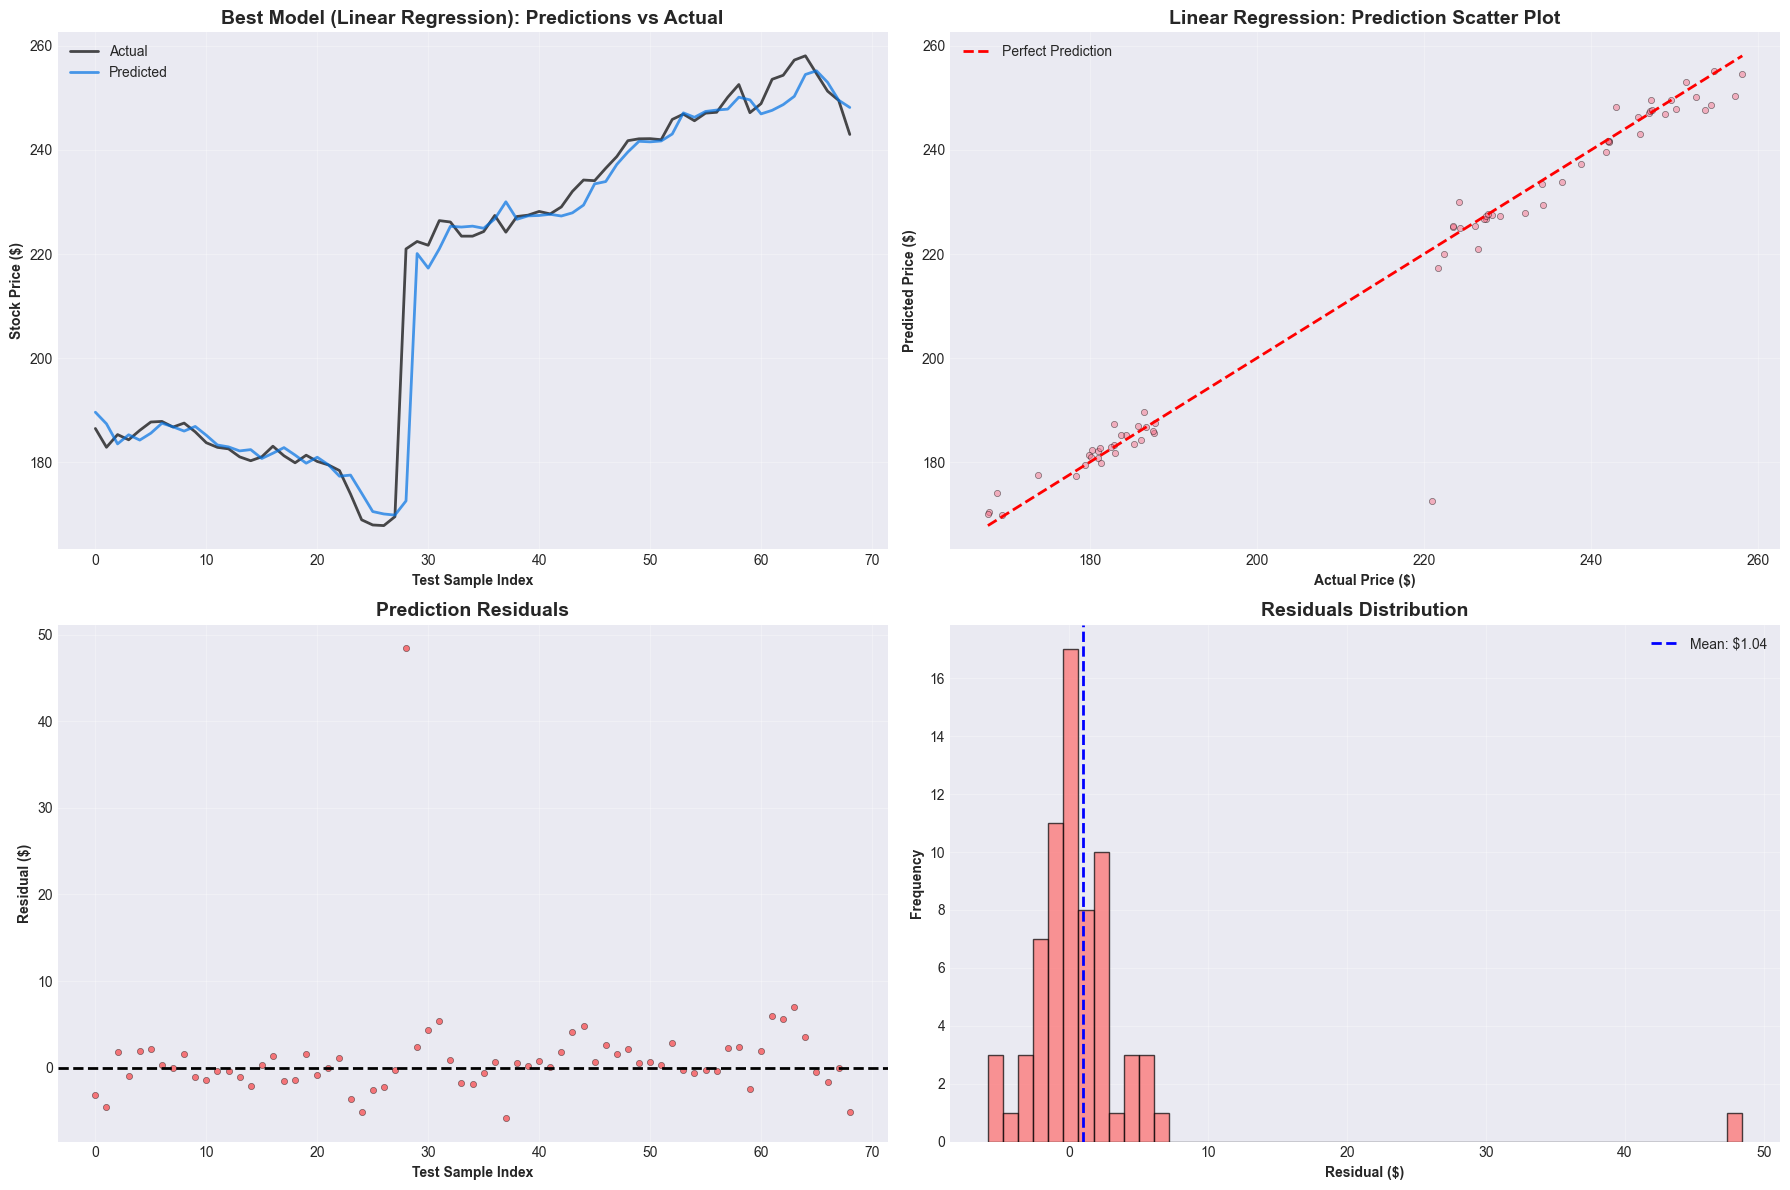

Saved: 04_predictions.png


In [21]:
best_model_name = max(results, key=lambda x: results[x]['test_r2'])
best_predictions = results[best_model_name]['predictions']

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

ax = axes[0, 0]
test_dates = df_ml.iloc[split_index:].index
ax.plot(range(len(y_test)), y_test.values, label='Actual', linewidth=2, color='black', alpha=0.7)
ax.plot(range(len(best_predictions)), best_predictions, label='Predicted', linewidth=2, color='#0071e3', alpha=0.7)
ax.set_xlabel('Test Sample Index', fontweight='bold')
ax.set_ylabel('Stock Price ($)', fontweight='bold')
ax.set_title(f'Best Model ({best_model_name}): Predictions vs Actual', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

ax = axes[0, 1]
ax.scatter(y_test, best_predictions, alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
ax.set_xlabel('Actual Price ($)', fontweight='bold')
ax.set_ylabel('Predicted Price ($)', fontweight='bold')
ax.set_title(f'{best_model_name}: Prediction Scatter Plot', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1, 0]
residuals = y_test.values - best_predictions
ax.scatter(range(len(residuals)), residuals, alpha=0.5, s=20, c='red', edgecolors='black', linewidth=0.5)
ax.axhline(0, color='black', linestyle='--', linewidth=2)
ax.set_xlabel('Test Sample Index', fontweight='bold')
ax.set_ylabel('Residual ($)', fontweight='bold')
ax.set_title('Prediction Residuals', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

ax = axes[1, 1]
ax.hist(residuals, bins=50, color='#ff6b6b', alpha=0.7, edgecolor='black')
ax.axvline(residuals.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: ${residuals.mean():.2f}')
ax.set_xlabel('Residual ($)', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Residuals Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('apple_visualizations/04_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("Saved: 04_predictions.png")

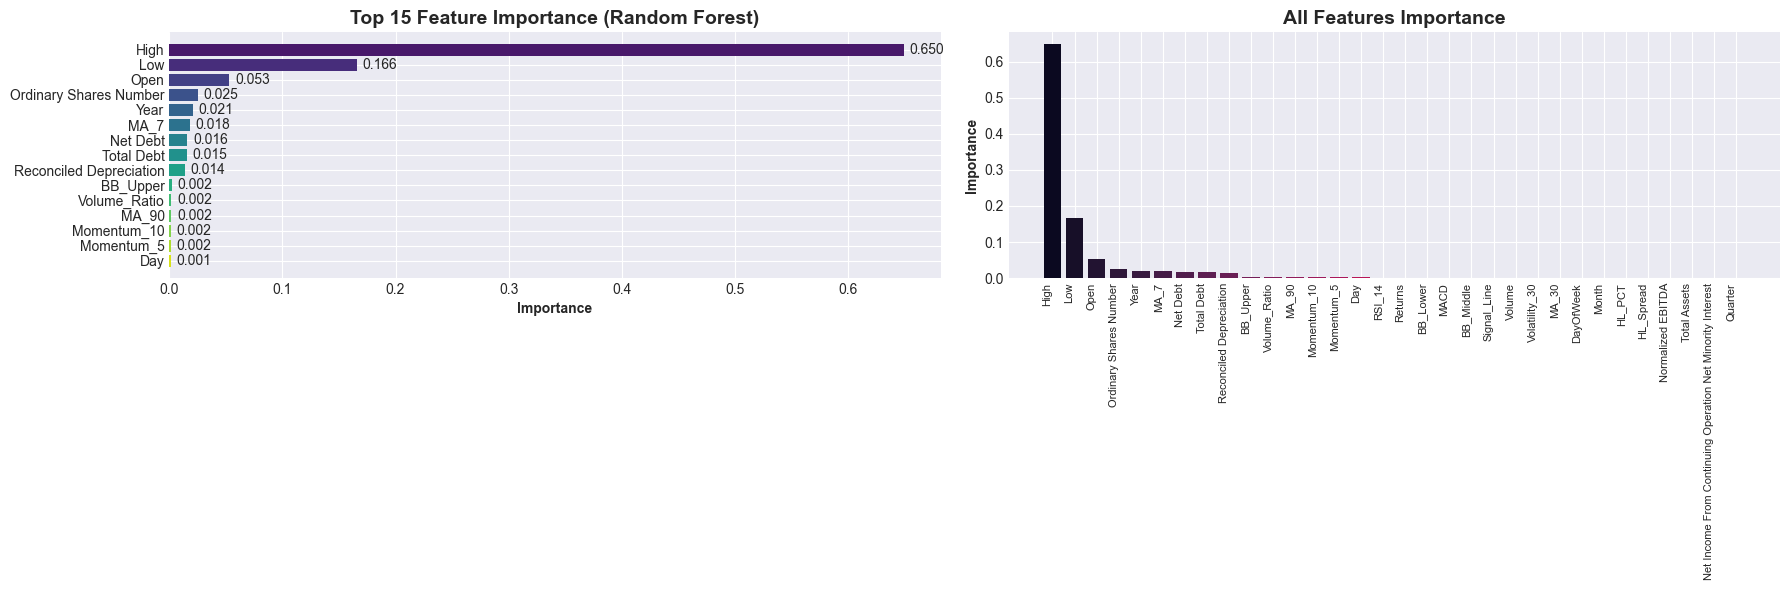

Saved: 05_feature_importance.png
 Saved: feature_importance_apple.csv


In [23]:
if hasattr(results['Random Forest']['model'], 'feature_importances_'):
    rf_model = results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    ax = axes[0]
    top_features = feature_importance.head(15)
    bars = ax.barh(top_features['feature'], top_features['importance'],
                   color=sns.color_palette("viridis", len(top_features)))
    ax.set_xlabel('Importance', fontweight='bold')
    ax.set_title('Top 15 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    for i, (feat, imp) in enumerate(zip(top_features['feature'], top_features['importance'])):
        ax.text(imp + 0.005, i, f'{imp:.3f}', va='center', fontsize=10)
    ax = axes[1]
    bars = ax.bar(range(len(feature_importance)), feature_importance['importance'],
                  color=sns.color_palette("rocket", len(feature_importance)))
    ax.set_xticks(range(len(feature_importance)))
    ax.set_xticklabels(feature_importance['feature'], rotation=90, ha='right', fontsize=8)
    ax.set_ylabel('Importance', fontweight='bold')
    ax.set_title('All Features Importance', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('apple_visualizations/05_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print("Saved: 05_feature_importance.png")
    feature_importance.to_csv('feature_importance_apple.csv', index=False)
    print(" Saved: feature_importance_apple.csv")

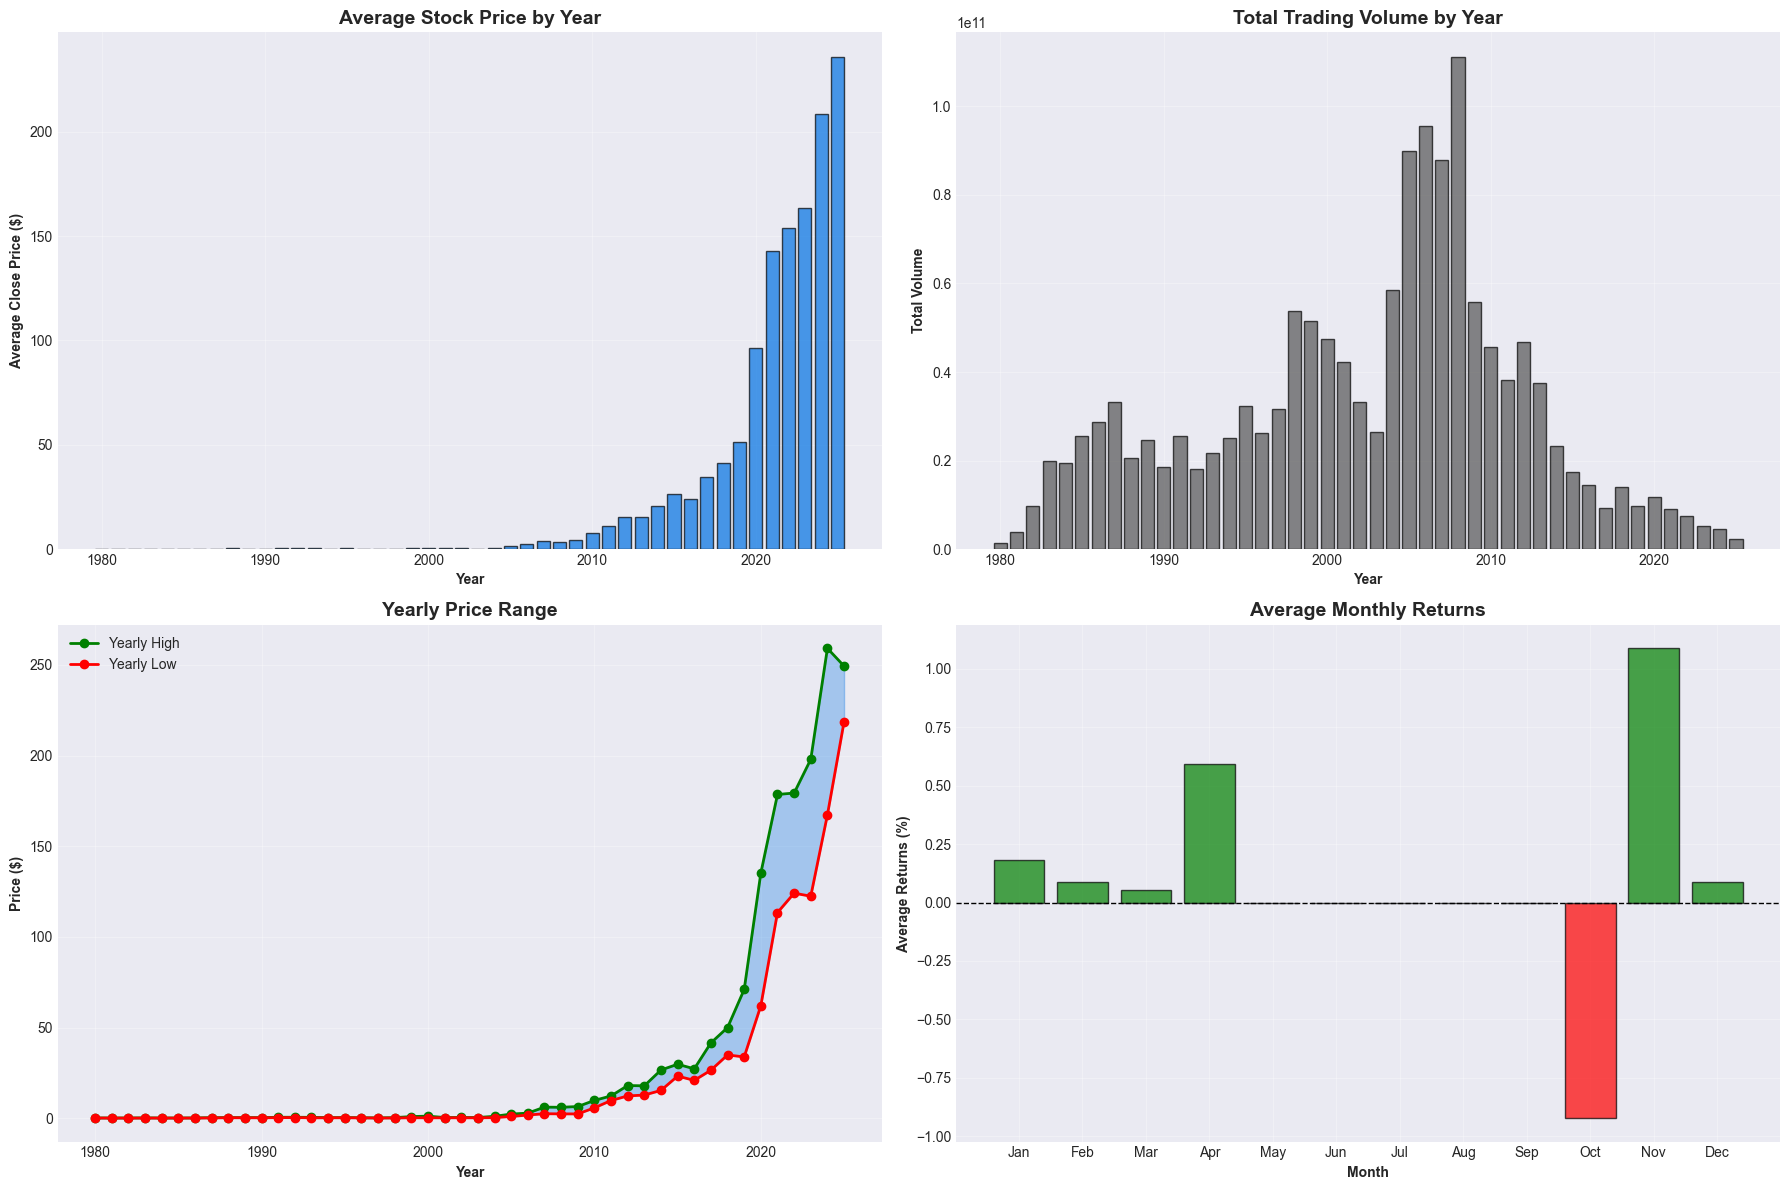

✓ Saved: 06_yearly_analysis.png


In [25]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

ax = axes[0, 0]
yearly_avg = df_historical.groupby('Year')['Close'].mean()
bars = ax.bar(yearly_avg.index, yearly_avg.values, color='#0071e3', alpha=0.7, edgecolor='black')
ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Average Close Price ($)', fontweight='bold')
ax.set_title('Average Stock Price by Year', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

ax = axes[0, 1]
yearly_volume = df_historical.groupby('Year')['Volume'].sum()
bars = ax.bar(yearly_volume.index, yearly_volume.values, color='#555555', alpha=0.7, edgecolor='black')
ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Total Volume', fontweight='bold')
ax.set_title('Total Trading Volume by Year', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

ax = axes[1, 0]
yearly_high = df_historical.groupby('Year')['High'].max()
yearly_low = df_historical.groupby('Year')['Low'].min()
years = yearly_high.index
ax.fill_between(years, yearly_low, yearly_high, alpha=0.3, color='#0071e3')
ax.plot(years, yearly_high, marker='o', label='Yearly High', linewidth=2, color='green')
ax.plot(years, yearly_low, marker='o', label='Yearly Low', linewidth=2, color='red')
ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Price ($)', fontweight='bold')
ax.set_title('Yearly Price Range', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1, 1]
monthly_returns = df_historical.groupby('Month')['Returns'].mean() * 100
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_vals = monthly_returns.reindex(np.arange(1, 13), fill_value=0).values
colors = ['green' if x > 0 else 'red' for x in monthly_vals]
bars = ax.bar(month_names, monthly_vals, color=colors, alpha=0.7, edgecolor='black')
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Month', fontweight='bold')
ax.set_ylabel('Average Returns (%)', fontweight='bold')
ax.set_title('Average Monthly Returns', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('apple_visualizations/06_yearly_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 06_yearly_analysis.png")


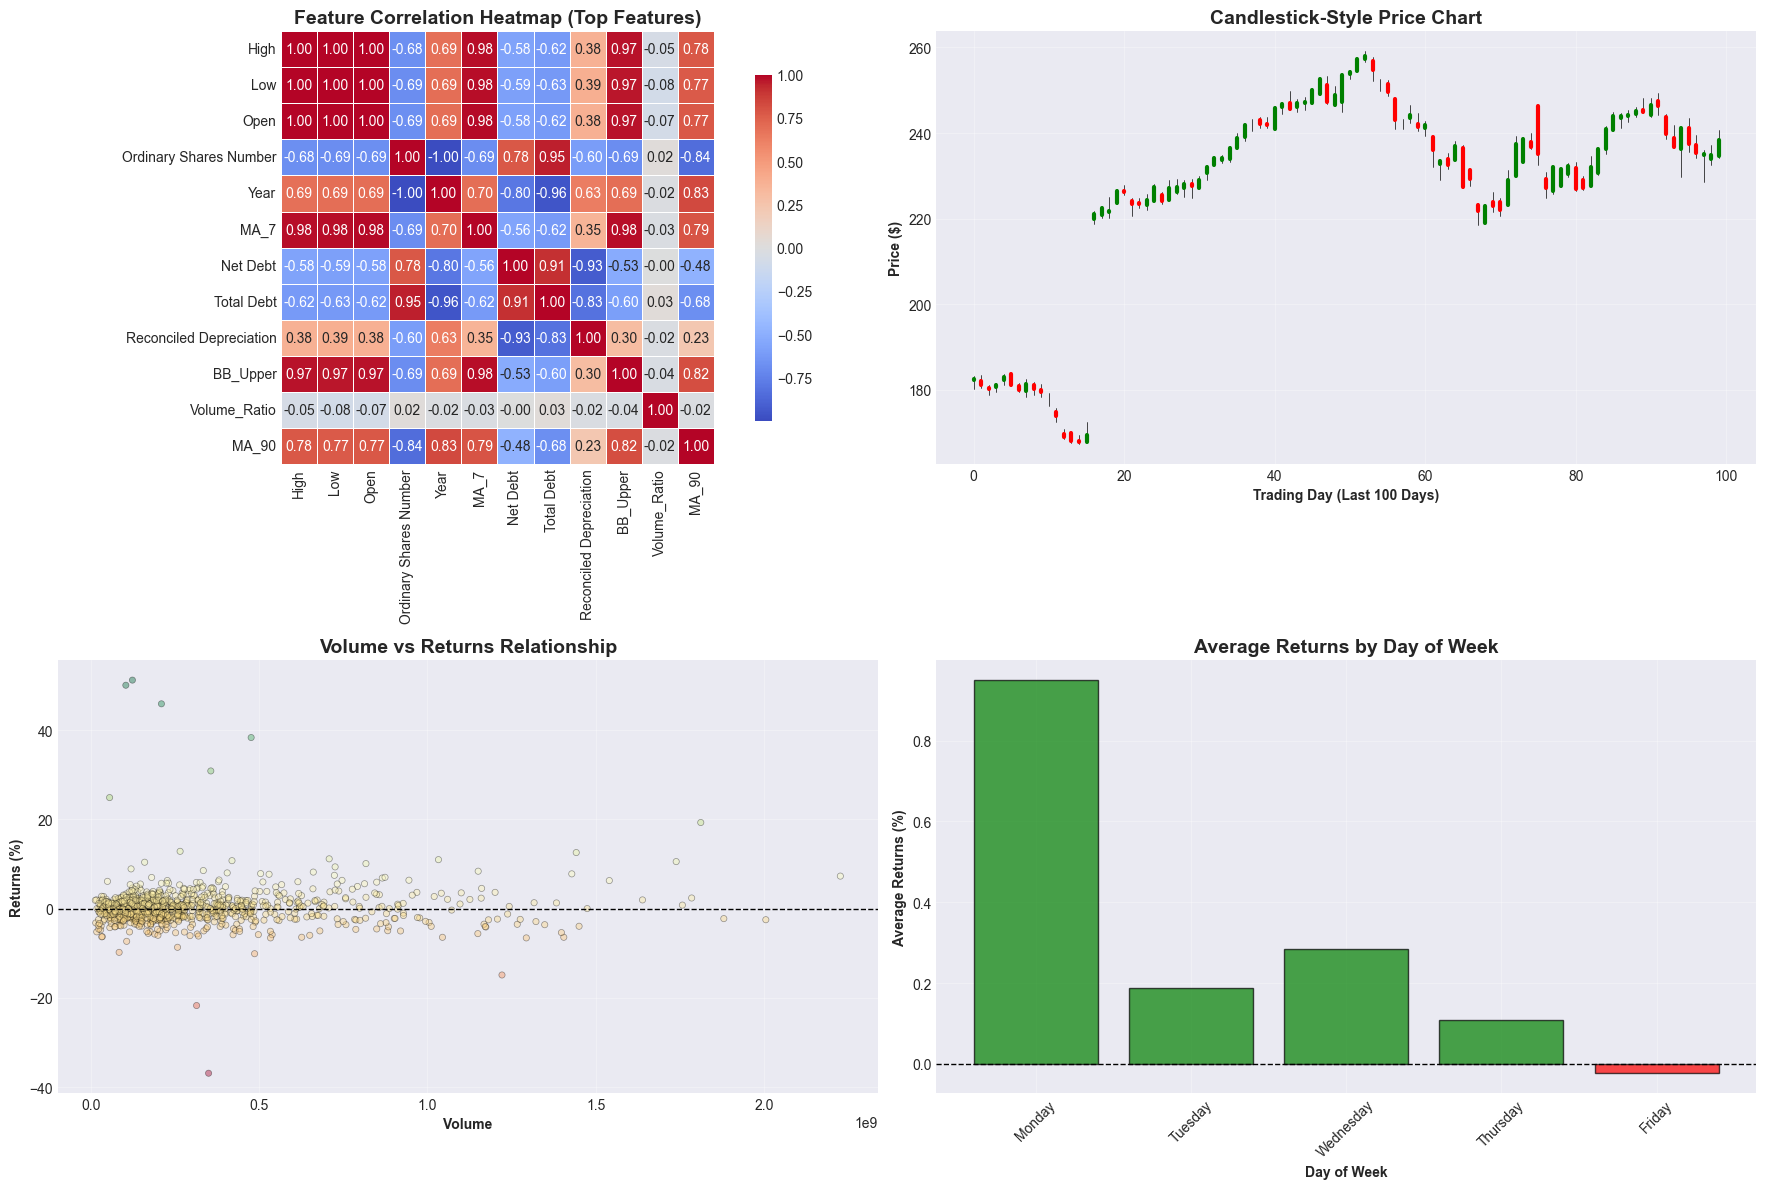

✓ Saved: 07_advanced_analytics.png


In [26]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

ax = axes[0, 0]
top_feat = feature_importance.head(12)['feature'].tolist() if 'feature_importance' in locals() else feature_columns[:12]
corr_matrix = df_ml[top_feat].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, ax=ax, cbar_kws={"shrink": 0.8})
ax.set_title('Feature Correlation Heatmap (Top Features)', fontsize=14, fontweight='bold')

ax = axes[0, 1]
recent_100 = df_historical.tail(100).reset_index(drop=True)
for idx, row in recent_100.iterrows():
    color = 'green' if row['Close'] >= row['Open'] else 'red'
    ax.plot([idx, idx], [row['Low'], row['High']], color='black', linewidth=0.5)
    ax.plot([idx, idx], [row['Open'], row['Close']], color=color, linewidth=3)
ax.set_xlabel('Trading Day (Last 100 Days)', fontweight='bold')
ax.set_ylabel('Price ($)', fontweight='bold')
ax.set_title('Candlestick-Style Price Chart', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

ax = axes[1, 0]
sample_data = df_historical.sample(min(1000, len(df_historical)))
ax.scatter(sample_data['Volume'], sample_data['Returns'] * 100, alpha=0.4, s=20,
           c=sample_data['Returns'], cmap='RdYlGn', edgecolors='black', linewidth=0.5)
ax.set_xlabel('Volume', fontweight='bold')
ax.set_ylabel('Returns (%)', fontweight='bold')
ax.set_title('Volume vs Returns Relationship', fontsize=14, fontweight='bold')
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.grid(alpha=0.3)

ax = axes[1, 1]
dow_returns = df_historical.groupby('DayOfWeek')['Returns'].mean() * 100
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
colors_dow = ['green' if x > 0 else 'red' for x in dow_returns.values[:5]]
bars = ax.bar(dow_names, dow_returns.values[:5], color=colors_dow, alpha=0.7, edgecolor='black')
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Day of Week', fontweight='bold')
ax.set_ylabel('Average Returns (%)', fontweight='bold')
ax.set_title('Average Returns by Day of Week', fontsize=14, fontweight='bold')
plt.setp(ax.get_xticklabels(), rotation=45)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('apple_visualizations/07_advanced_analytics.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 07_advanced_analytics.png")

In [27]:
best_model_name = max(results, key=lambda x: results[x]['test_r2'])
best_result = results[best_model_name]

report = f"""
{'='*80}
APPLE STOCK PRICE PREDICTION - MODEL EVALUATION REPORT
{'='*80}

DATASET INFORMATION:
- Historical Data Points: {len(df_historical)}
- Date Range: {df_historical['Date'].min()} to {df_historical['Date'].max()}
- Features: {len(feature_columns)}
- Training Samples: {len(X_train)}
- Test Samples: {len(X_test)}

{'='*80}
MODEL PERFORMANCE SUMMARY (Sorted by R²):
{'='*80}
"""

for name, result in sorted(results.items(), key=lambda x: x[1]['test_r2'], reverse=True):
    report += f"""
{name}:
  Test R²:     {result['test_r2']:.4f}
  Test RMSE:   ${result['test_rmse']:.2f}
  Test MAE:    ${result['test_mae']:.2f}
  Test MAPE:   {result['test_mape']:.2f}%
"""

report += f"""
{'='*80}
BEST MODEL: {best_model_name}
{'='*80}
Test R² Score:  {best_result['test_r2']:.4f}
Test RMSE:      ${best_result['test_rmse']:.2f}
Test MAE:       ${best_result['test_mae']:.2f}
Test MAPE:      {best_result['test_mape']:.2f}%

{'='*80}
KEY STATISTICS:
{'='*80}
Current Price (Latest):     ${df_historical['Close'].iloc[-1]:.2f}
52-Week High:               ${df_historical['High'].tail(252).max():.2f}
52-Week Low:                ${df_historical['Low'].tail(252).min():.2f}
Average Daily Volume (1Y):  {df_historical['Volume'].tail(252).mean():,.0f}
Average Daily Return:       {df_historical['Returns'].mean()*100:.4f}%
Annualized Volatility:      {df_historical['Returns'].std()*np.sqrt(252)*100:.2f}%

{'='*80}
FILES GENERATED:
{'='*80}
1. apple_merged_data.csv - Merged historical & financial data
2. model_performance_apple.csv - Model comparison metrics
3. feature_importance_apple.csv - Feature importance rankings
4. apple_visualizations/ - 7 comprehensive visualizations

VISUALIZATIONS:
- 01_stock_overview.png
- 02_technical_indicators.png
- 03_model_performance.png
- 04_predictions.png
- 05_feature_importance.png
- 06_yearly_analysis.png
- 07_advanced_analytics.png

{'='*80}
END OF REPORT
{'='*80}
"""

with open('APPLE_STOCK_MODEL_REPORT.txt', 'w') as f:
    f.write(report)
print(" Saved: APPLE_STOCK_MODEL_REPORT.txt")

# Save predictions
predictions_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': best_predictions,
    'Error': y_test.values - best_predictions,
    'Percent_Error': ((y_test.values - best_predictions) / y_test.values * 100)
})
predictions_df.to_csv('apple_predictions.csv', index=False)
print(" Saved: apple_predictions.csv")

# Save best model
import pickle
with open(f'best_model_{best_model_name.replace(" ", "_").lower()}_apple.pkl', 'wb') as f:
    pickle.dump(best_result['model'], f)
print(f"Saved: best_model_{best_model_name.replace(' ', '_').lower()}_apple.pkl")

# Save scaler
with open('scaler_apple.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Saved: scaler_apple.pkl")

 Saved: APPLE_STOCK_MODEL_REPORT.txt
 Saved: apple_predictions.csv
Saved: best_model_linear_regression_apple.pkl
Saved: scaler_apple.pkl
